## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [34]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

%matplotlib inline
#%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        
        
         # Draw and display the corners

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(gray.shape[::-1])

(1280, 720)


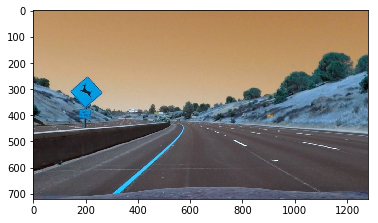

In [35]:
def undistort_img(img, objpoints, imgpoints):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


test_img = cv2.imread('../test_images/test2.jpg')

undst_img = undistort_img(test_img, objpoints, imgpoints)

plt.imshow(undst_img)


## Perspective Transform

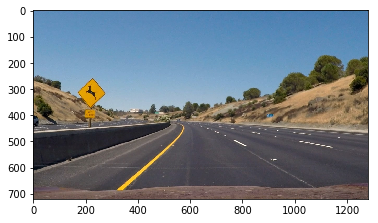

In [36]:
import matplotlib.image as mpimg

%matplotlib inline

img = mpimg.imread('../test_images/test2.jpg')
#test_img = cv2.imread('../test_images/test5.jpg')

plt.imshow(img)
#print(img.shape[1])

In [37]:
# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(undst_img):
    img_size = (undst_img.shape[1], undst_img.shape[0])
    #src = np.float32([[580, 460],[710,460],[1150,720],[150,720]])
    src = np.float32([[280, 650],[1080,650],[800,490],[500,490]])
    #dst = np.float32([[100,gray.shape[0]],[200,0],[gray.shape[1],0],[gray.shape[1], gray.shape[0]]])
    dst = np.float32([[0,700],[1200,700],[1200,100],[0,100]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undst_img, M, img_size)
        
    return warped, M, Minv

In [38]:
top_down, perspective_M, Minv = corners_unwarp(undst_img)

## And so on and so forth...

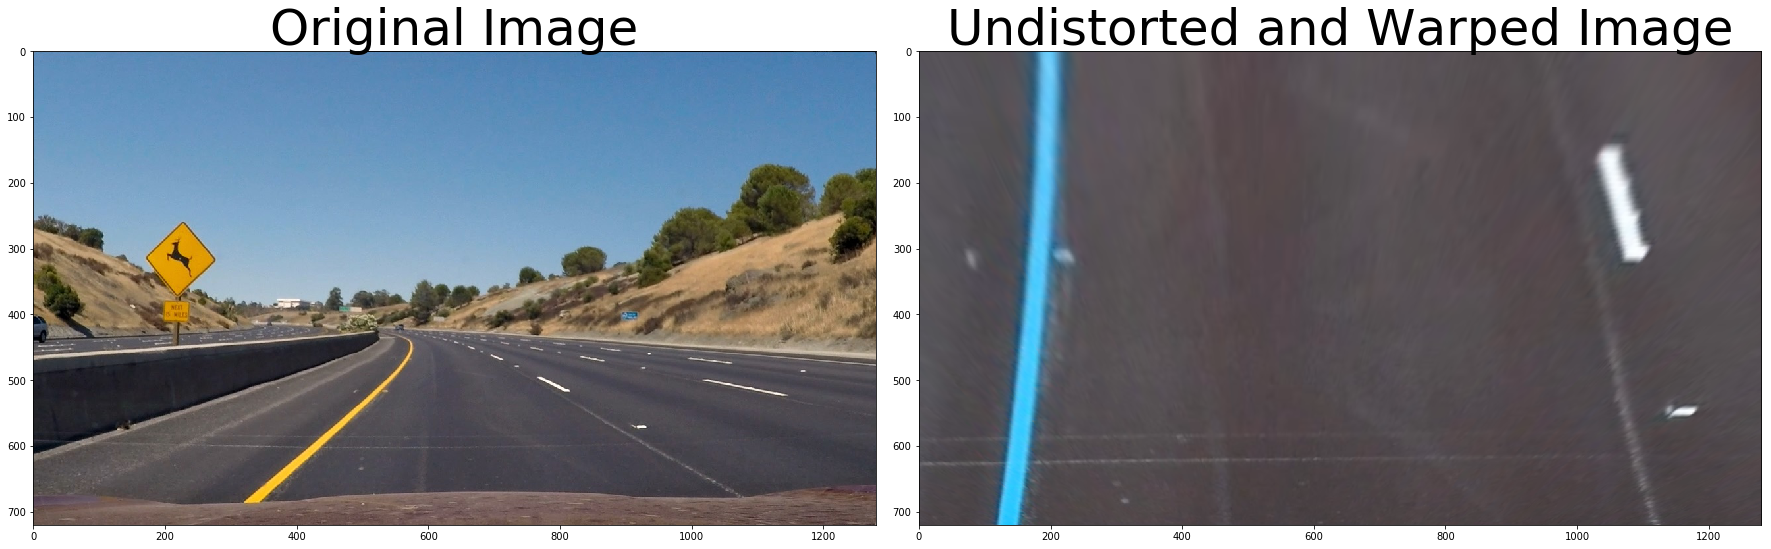

In [39]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


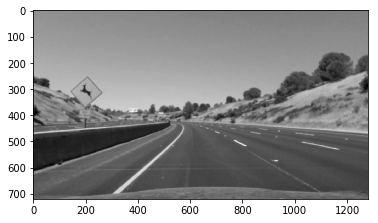

In [40]:

gray = cv2.cvtColor(undst_img, cv2.COLOR_BGR2GRAY)
    
gray = cv2.GaussianBlur(gray,(9,9),0)

plt.imshow(gray, cmap='gray')


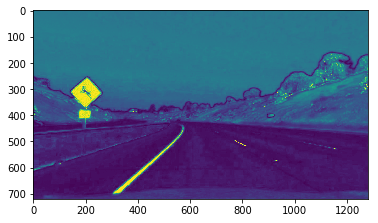

In [41]:
# Convert to HLS color space and separate the S channel
hls = cv2.cvtColor(undst_img, cv2.COLOR_BGR2HLS)
s = hls[:,:,2]

plt.imshow(s)
    

In [42]:
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
 
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

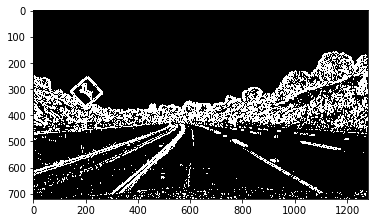

In [43]:
sobelx = abs_sobel_thresh(gray, orient='x', thresh_min=10, thresh_max=255)

plt.imshow(sobelx, cmap='gray')

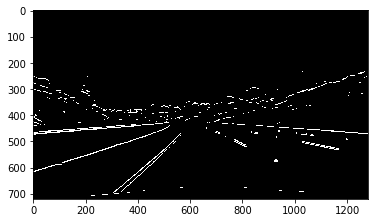

In [44]:
sobely= abs_sobel_thresh(gray, orient='y', thresh_min=85, thresh_max=255)

plt.imshow(sobely, cmap='gray')

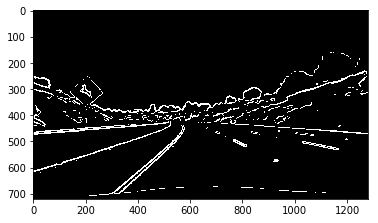

In [45]:
mag_thresh=mag_thresh(gray, sobel_kernel=11, mag_thresh=(80, 255))

plt.imshow(mag_thresh, cmap='gray')

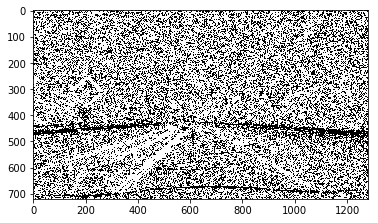

In [46]:
dir_thresh =dir_threshold(undst_img, sobel_kernel=11, thresh=(0.4,1.4))

plt.imshow(dir_thresh, cmap='gray')

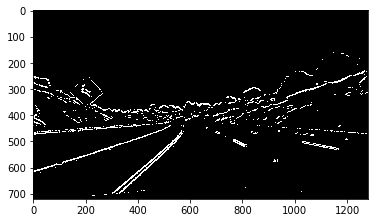

In [47]:
combined = np.zeros_like(dir_thresh)
combined[((sobelx == 1) & (sobely == 1)) | ((mag_thresh == 1) & (dir_thresh == 1))] = 1
#combined[((sobelx == 1) & (sobely == 1) & (mag_thresh == 1))] = 1

plt.imshow(combined, cmap='gray')

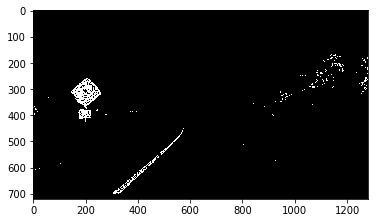

In [48]:
s_binary = np.zeros_like(combined)
s_binary[(s > 140) & (s < 255)] = 1
plt.imshow(s_binary, cmap='gray')

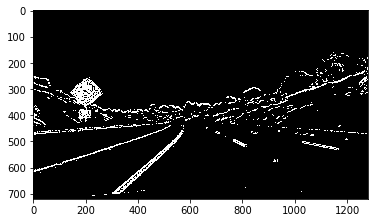

In [49]:
color_binary = np.zeros_like(combined)
color_binary[(s_binary > 0) | (combined > 0)] = 1

plt.imshow(color_binary, cmap='gray')


In [50]:
def region_of_interest(img, vertices):
        """
         Applies an image mask.
    
        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        """
        #defining a blank mask to start with
        mask = np.zeros_like(img)   
    
        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        
        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)
    
        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

In [51]:
 vertices = np.array([[(150,720),(610, 410), (680, 410), (1200,720)]], dtype=np.int32)

(720, 1280)


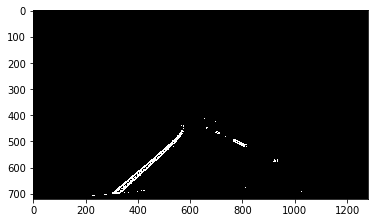

In [52]:
masked = region_of_interest(color_binary, vertices)
print(masked.shape)
plt.imshow(masked, cmap='gray')

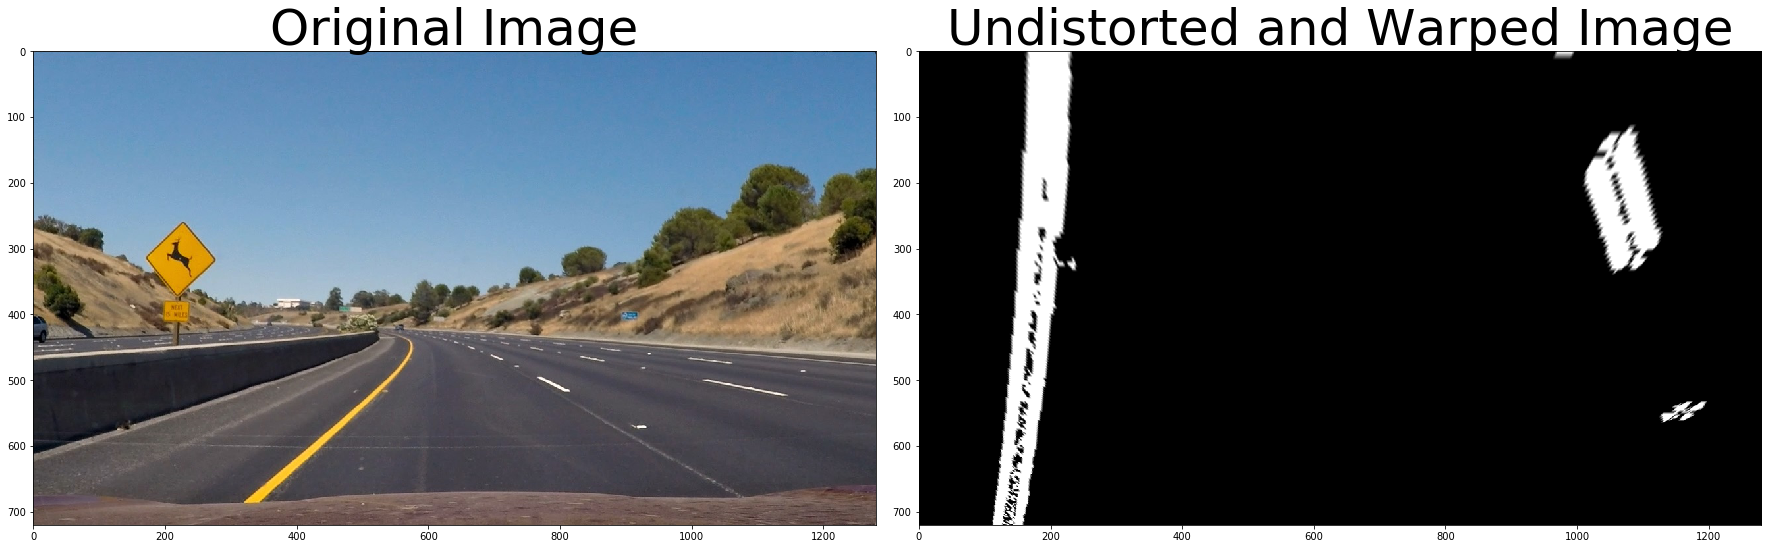

In [53]:
top_down, perspective_M, Minv= corners_unwarp(masked)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [54]:
binary_warped = top_down
print(top_down.shape)
print(top_down)
print(top_down.ndim)

(720, 1280)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
2


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[ 0.  0.  0. ...,  0.  0.  0.]


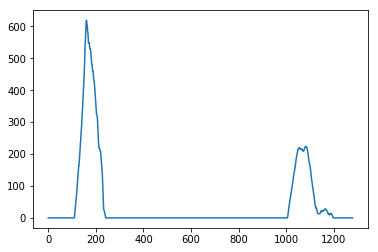

In [55]:
top_down[top_down > 0] = 1

print(top_down)
histogram = np.sum(top_down[720//9:,:], axis=0)
plt.plot(histogram)
print(histogram)



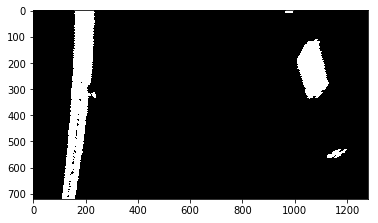

In [56]:
plt.imshow(top_down, cmap='gray')

3
640
160
1083


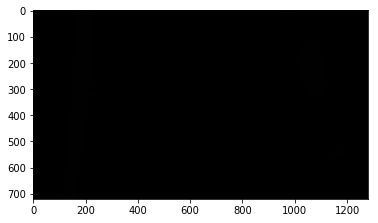

In [57]:

out_img = np.dstack((top_down, top_down, top_down))*255
print(out_img.ndim)


midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print(midpoint)
print(leftx_base)
print(rightx_base)


plt.imshow(out_img)

In [81]:
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

print(window_height)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
print(len(left_lane_inds))

80
9


In [82]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)
print(left_lane_inds.shape)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
print(leftx.shape)
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(46094,)
(46094,)


(720, 0)

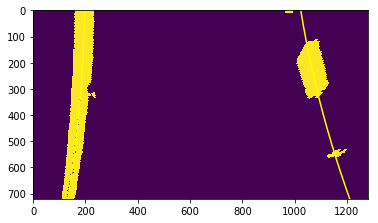

In [60]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#plt.imshow(out_img)
plt.imshow(top_down)

#masked_image = cv2.bitwise_and(out_img, top_down)

#print(top_down.ndim)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


2
(720, 1280)


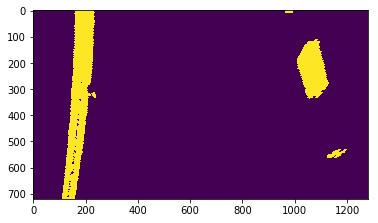

In [61]:
plt.imshow(top_down)
print(top_down.ndim)
print(top_down.shape)

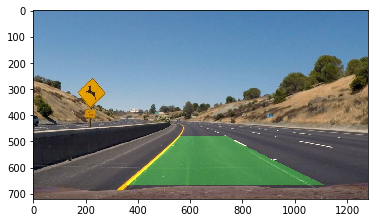

In [62]:
warp_zero = np.zeros_like(top_down).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

plt.imshow(result)

3
(720, 1280, 3)
1280


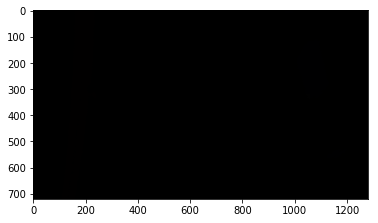

In [69]:
plt.imshow(out_img)
print(out_img.ndim)
print(out_img.shape)

print(out_img.shape[1])

(720, 0)

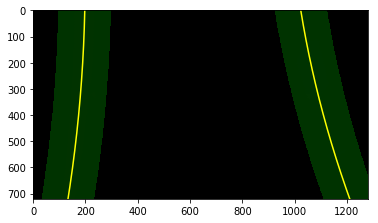

In [64]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

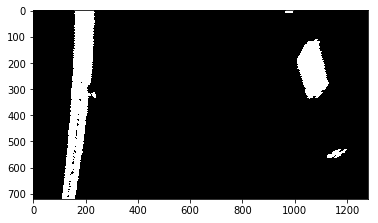

In [65]:
plt.imshow(top_down, cmap='gray')


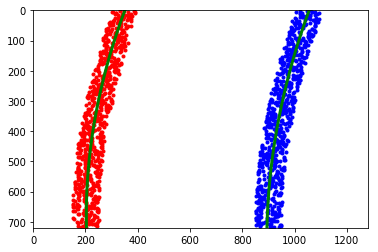

In [66]:
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data

#f, (ax1, ax2) = plt.subplots(1,2,figsize=(24,9))
#f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))

#plt.figure()
#plt.subplot(121)
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
#plt.subplot(122)
#plt.imshow(top_down, cmap='gray')
#f.tight_layout()

In [67]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

1575.103283 1817.85581666


In [71]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m
print(ploty.shape)
print(leftx.shape)

516.901669256 m 596.482026444 m
(720,)
(720,)


In [ ]:
def draw_poly(image, warped, yvals, left_fitx, right_fitx, 
              left_lane_x, left_lane_y, right_lane_x, right_lane_y, Minv, curvature):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    # Put text on an image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(curvature))
    cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    # Find the position of the car
    pts = np.argwhere(newwarp[:,:,1])
    position = find_position(pts)
    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
    cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
    return result





In [ ]:
def corners_unwarp(undst_img):
    img_size = (undst_img.shape[1], undst_img.shape[0])
    #src = np.float32([[580, 460],[710,460],[1150,720],[150,720]])
    src = np.float32([[280, 650],[1080,650],[800,490],[500,490]])
    #dst = np.float32([[100,gray.shape[0]],[200,0],[gray.shape[1],0],[gray.shape[1], gray.shape[0]]])
    dst = np.float32([[0,700],[1200,700],[1200,100],[0,100]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undst_img, M, img_size)
        
    return warped, M, Minv

def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
 
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def find_position(pts):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    position = 1280/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (position - center)*xm_per_pix


def region_of_interest(img, vertices):
        """
         Applies an image mask.
    
        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        """
        #defining a blank mask to start with
        mask = np.zeros_like(img)   
    
        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        
        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)
    
        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image
def detect_lanes(binary_warped,img, Minv):  
    binary_warped[binary_warped > 0] = 1
    histogram = np.sum(binary_warped[720//9:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
        # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 


    
    #print(leftx.shape)
    #print(ploty.shape)
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    #print(ploty.shape)
    #print(leftx.shape)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    #left_curverad  = find_curvature(ploty, leftx)

    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(left_curverad))
    cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    # Find the position of the car
    #pts = np.argwhere(newwarp[:,:,1])
    #position = find_position(pts)
    #if position < 0:
     #   text = "Vehicle is {:.2f} m left of center".format(-position)
    #else:
     #   text = "Vehicle is {:.2f} m right of center".format(position)
        
    #cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
    
    
    return result
    
    